In [1]:
include("model.jl")
include("Parser.jl")
using JuMP
using Plots

## Data processing

In [2]:
n, m, x_VC, y_VC, x_loc, y_loc, Q, C, q, f, p, tc, B, R, localities_with_high_priorities, M = parse_instance("./Instances/coord20-5-1b_processed.dat")
print(f)
print(C)

[12286, 12031, 6995, 8502, 12790][300, 300, 300, 300, 300]

In [3]:
# Create the distance matrix
distance_matrix = zeros(Float64, m, n)

for i in 1:m 
    for j in 1:n
        distance_matrix[i, j] = sqrt((x_VC[i] - x_loc[j])^2 + (y_VC[i] - y_loc[j])^2)
    end
end


# Create reachability matrix a
A = zeros(Int, n, n)


for i in 1:m
    for j in 1:n
        if distance_matrix[i, j] <= R[i]
            A[i, j] = 1
        end
    end
end

In [4]:
D = zeros(Float64, n+m, n+m)
#The n first rows/cols of D relate to the localities, the m last to the VC
#In other words, calling D[i,j] for i in I, j in J corresponds to call D[i+n,j]
for i in 1:m+n
    for j in 1:m+n
        if i <= n && j <= n
            # Both indices in `loc`
            D[i, j] = sqrt((x_loc[i] - x_loc[j])^2 + (y_loc[i] - y_loc[j])^2)
        elseif i > n && j > n
            # Both indices in `VC`
            D[i, j] = sqrt((x_VC[i - n] - x_VC[j - n])^2 + (y_VC[i - n] - y_VC[j - n])^2)
        elseif i > n && j <= n
            # i in `VC`, j in `loc`
            D[i, j] = sqrt((x_VC[i - n] - x_loc[j])^2 + (y_VC[i - n] - y_loc[j])^2)
        else
            # i in `loc`, j in `VC`
            D[i, j] = sqrt((x_loc[i] - x_VC[j - n])^2 + (y_loc[i] - y_VC[j - n])^2)
        end
    end
end

## Models Creation

### OptVax1

In [5]:
model_OptVax1 = solve_OptVax1(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)

obj_val = objective_value(model_OptVax1)
println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+04]
  Cost   [1e+01, 2e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+04]
Presolving model
6256 rows, 3048 cols, 27823 nonzeros  0s
4752 rows, 3045 cols, 24710 nonzeros  0s
4335 rows, 2824 cols, 86234 nonzeros  1s
Objective function is integral with scale 1

Solving MIP model with:
   4335 rows
   2824 cols (2824 binary, 0 integer, 0 implied int., 0 continuous)
   86234 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   308             -inf                 inf        0      0      0         0     1.5s
         0       0         0   0.00%   308             -inf                 inf        0      0     10       824    

### OptVax2

In [6]:
model_OptVax2 = solve_OptVax2(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
obj_val = objective_value(model_OptVax2)
println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [7e-02, 1e+04]
  Cost   [1e+01, 2e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+04]
Presolving model
3382 rows, 3173 cols, 22371 nonzeros  0s
3157 rows, 2949 cols, 20561 nonzeros  0s
Objective function is integral with scale 1

Solving MIP model with:
   3157 rows
   2949 cols (2949 binary, 0 integer, 0 implied int., 0 continuous)
   20561 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   308             -inf                 inf        0      0      0         0     0.6s
         0       0         0   0.00%   308             -inf                 inf        0      0      2       213     0.6s
         1       0         1 100.00

In [10]:
function plot_solution(model, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)
    # Retrieve the optimized values of y, z, and delta from the model
    y_values = value.(model[:y])
    z_values = value.(model[:z])  # z_values is a 3D array with dimensions (i, j, k)
    delta_values = value.(model[:delta])

    # Create a new plot
    color = :blue
    plt = plot()
        # Plot loc points without adding them to the legend (but with single labels for groups)
    first_black = true
    first_green = true
    for j in 1:n
        if j in localities_with_high_priorities
            # Plot green square points and add label only for the first one
            if first_green
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:green, marker=:square, aspect_ratio=:equal, label="High priority")
                first_green = false
            else
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:green, marker=:square, aspect_ratio=:equal, label="")
            end
        else
            # Plot black circle points and add label only for the first one
            if first_black
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:black, marker=:circle, aspect_ratio=:equal, label="Low priority")
                first_black = false
            else
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:black, marker=:circle, aspect_ratio=:equal, label="")
            end
        end
    end

    # For each VC point, check if y[i] is 1; if so, plot in red and add a shaded circle
    for i in 1:length(x_VC) 
        if y_values[i] == 1
            # Plot the VC point in red
            scatter!(plt, [x_VC[i]], [y_VC[i]], color=:red, marker=:star5, label="VC")

            # Draw a shaded circle of radius R[i] around the VC location
            θ = range(0, 2π, length=100)
            circle_x = x_VC[i] .+ R[i] .* cos.(θ)
            circle_y = y_VC[i] .+ R[i] .* sin.(θ)
            plot!(plt, circle_x, circle_y, lw=1.5, linecolor=:red, label="", fillalpha=0.1, fillcolor=:red)
        end
    end

    # Create a color gradient (you can use other gradient types too)
    color_map = [:blue,:teal,:green,:darkred,:orange]

    # For all z[i,j,k], draw arrows only if z[i,j,k] == 1 for any k
    for i in 1:(m+n)
        for j in 1:(m+n)
            # Check if z[i, j, k] == 1 for any k
            for k in 1:M
                if z_values[i, j, k] == 1.0
                    # Scale the color based on the value of k, you can normalize it if needed
                    color = color_map[k]  # This gives a color based on the value of k

                    # Create the arrows with the color mapped to k
                    if i <= n && j <= n
                        # Arrow from loc[i] to loc[j]
                        dx = x_loc[j] - x_loc[i]
                        dy = y_loc[j] - y_loc[i]
                        quiver!(plt, [x_loc[i]], [y_loc[i]], quiver=([dx], [dy]), color=color, linewidth=1, arrowhead=2)
                    elseif i > n && j > n
                        # Arrow from VC[i] to VC[j]
                        dx = x_VC[j - n] - x_VC[i - n]
                        dy = y_VC[j - n] - y_VC[i - n]
                        quiver!(plt, [x_VC[i - n]], [y_VC[i - n]], quiver=([dx],[dy]), color=color, linewidth=1, arrowhead=2)
                    elseif i <= n && j > n
                        # Arrow from loc[i] to VC[j]
                        dx = x_VC[j - n] - x_loc[i]
                        dy = y_VC[j - n] - y_loc[i]
                        quiver!(plt, [x_loc[i]], [y_loc[i]], quiver=([dx], [dy]), color=color, linewidth=1, arrowhead=2)
                    elseif i > n && j <= n
                        # Arrow from VC[i] to loc[j]
                        dx = x_loc[j] - x_VC[i - n]
                        dy = y_loc[j] - y_VC[i - n]
                        quiver!(plt, [x_VC[i - n]], [y_VC[i - n]], quiver=([dx], [dy]), color=color, linewidth=1, arrowhead=2)
                    end
                end
            end
        end
    end

    # Display the final plot
    savefig(plt, "test.pdf")
    display(plt)
end


plot_solution (generic function with 1 method)

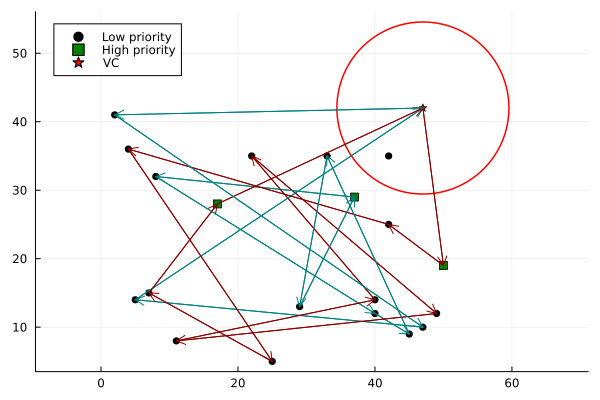

In [11]:
plot_solution(model_OptVax1, x_VC, y_VC, x_loc, y_loc, R,n,m,M, localities_with_high_priorities)

In [9]:
print(value.(model_OptVax1[:delta]))
print(value.(model_OptVax1[:y]))

[0.0, 1.0, 0.0, 1.0, 0.0]1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:5
And data, a 5-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0